In [13]:
# !pip install openai==0.28.0 datasets transformers sentence-transformers faiss-cpu

In [14]:
import openai
import os
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    default_data_collator,
)
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import matplotlib.pyplot as plt

In [15]:
openai.api_key = "YOUR_API_KEY"

model = "gpt-4o-2024-11-20"


def perform_qnli(question, sentence, context=None):
    prompt = f"""
    Decide if the following sentence answers the given question (entailment). Only answer with one of the following: 'Yes', 'No'.
    {'' if context == None else f"Some examples are: {context}"}
    Identify the following:
    QUESTION={question}
    SENTENCE={sentence}
    ENTAILMENT:
    """

    try:
        response = openai.Completion.create(
            engine=model,
            prompt=prompt,
            max_tokens=3,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print("Error:", e)
        return "Error"

In [16]:
GLUE_TASK_TO_KEYS = {
    "qnli": ("question", "sentence"),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
TRAIN_SET_SIZE = 50_000
VAL_SET_SIZE = 5_463


def get_dataset(split, inds=None):
    raw_datasets = load_dataset("glue", "qnli")
    sentence1_key, sentence2_key = GLUE_TASK_TO_KEYS["qnli"]

    tokenizer = AutoTokenizer.from_pretrained(
        "gchhablani/bert-base-cased-finetuned-qnli", use_fast=True
    )

    def preprocess_function(examples):
        args = (examples[sentence1_key], examples[sentence2_key])
        return tokenizer(*args, padding="max_length", max_length=128, truncation=True)

    raw_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        desc="Running tokenizer on dataset",
    )

    if split == "train":
        ds = raw_datasets["train"]
    else:
        ds = raw_datasets["validation"]
    return ds


ds_train = get_dataset("train").select(range(TRAIN_SET_SIZE))
ds_val = get_dataset("val").select(range(500))

In [17]:
trak_scores_data = pd.read_csv("bert_trak_scores.csv")


def get_context(validation_index, positive_score=None):
    if positive_score == True:
      trak_data = trak_scores_data[trak_scores_data["score"] > 0]
    elif positive_score == False:
      trak_data = trak_scores_data[trak_scores_data["score"] < 0]
    else:
      trak_data = trak_scores_data

    questions = trak_data[trak_data["val_index"] == validation_index][
        "question"
    ].tolist()
    sentences = trak_data[trak_data["val_index"] == validation_index][
        "sentence"
    ].tolist()
    labels = trak_data[trak_data["val_index"] == validation_index][
        "train_label"
    ].tolist()

    contexts = [
        f"QUESTION={q} SENTENCE={s} ENTAILMENT={'YES' if l == 0 else 'NO'}"
        for q, s, l in zip(questions, sentences, labels)
    ]
    contexts = "\n".join(contexts)

    return contexts


trak_scores_data.head()

,val_index,train_index,train_label,input,score,question,sentence
0,0,0,0,What came into force after the new constitutio...,5.316,Why does Sowell believe that there is little t...,Sowell writes that affirmative action policies...
1,0,0,0,What came into force after the new constitutio...,4.836,What type of language is French considered to be?,Rome's expansion spread Latin throughout Europ...
2,0,0,1,What came into force after the new constitutio...,4.080,Which direction does the water flow in this area?,"From this point, it then flows generally east ..."
3,0,0,0,What came into force after the new constitutio...,3.810,"In the nominative, genitive, partitive, illati...","In Estonian, nouns and pronouns do not have gr..."
4,0,0,0,What came into force after the new constitutio...,3.188,What should women do if they are using antibio...,Clinicians have recommended that extra contrac...


In [18]:
# Implement RAG

train_questions = ds_train["question"]
train_sentences = ds_train["sentence"]
train_labels = ds_train["label"]

# Combine questions and answers into a single context-answer pair
qa_pairs = [
    f"QUESTION={question} SENTENCE={train_sentences[idx]}"
    for idx, question in enumerate(train_questions)
]
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
qa_embeddings = embedding_model.encode(qa_pairs, convert_to_numpy=True)

index = faiss.IndexFlatL2(qa_embeddings.shape[1])
index.add(qa_embeddings)

gen_tokenizer = AutoTokenizer.from_pretrained("t5-small")
gen_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [19]:
def retrieve_qa_pairs(question, top_k=5):
    # Encode the question
    question_embedding = embedding_model.encode([question], convert_to_numpy=True)

    # Retrieve the top-k most relevant QA pairs
    distances, indices = index.search(question_embedding, top_k)
    retrieved_qa_pairs = [
        f"{qa_pairs[idx]} ENTAILMENT={'YES' if train_labels[idx] == 1 else 'NO'}"
        for idx in indices[0]
    ]

    return "\n".join(retrieved_qa_pairs)


question = """Where is the Eiffel Tower?"""
answer = retrieve_qa_pairs(question)
print(answer)

QUESTION=Where was the Eiffel Tower revealed? SENTENCE=Late in the 19th century, Paris hosted two major international expositions: the 1889 Universal Exposition, was held to mark the centennial of the French Revolution and featured the new Eiffel Tower; and the 1900 Universal Exposition, which gave Paris the Pont Alexandre III, the Grand Palais, the Petit Palais and the first Paris Métro line. ENTAILMENT=NO
QUESTION=In what year was the Eiffel Tower built? SENTENCE=The notable architectural landmarks of Paris include Notre Dame Cathedral (12th century); the Sainte-Chapelle (13th century); the Eiffel Tower (1889); and the Basilica of Sacré-Cœur on Montmartre (1914). ENTAILMENT=NO
QUESTION=In what year was the Eiffel Tower built? SENTENCE=In 2014 Paris received 22.4 million visitors, making it one of the world's top tourist destinations. ENTAILMENT=YES
QUESTION=Who designed the Gehry Tower? SENTENCE=Some other popular sights are the Waterloo Column, the Laves House, the Wangenheim Palace

In [20]:
def convert_prediction_to_label(prediction):
    return 1 if "yes" in prediction.lower() else 0 if "no" in prediction.lower() else None 

data = {
    "question": [],
    "sentence": [],
    "label": [],
    "prediction": [],
    "prediction_pe": [],
    "prediction_pe_positive": [],
    "prediction_pe_negative": [],
    "prediction_rag": [],
}
if os.path.exists("gpt_qnli_predictions.csv"):
    gpt_qnli_predictions = pd.read_csv("gpt_qnli_predictions.csv")
    data = {
        "question": gpt_qnli_predictions["question"].tolist(),
        "sentence": gpt_qnli_predictions["sentence"].tolist(),
        "label": gpt_qnli_predictions["label"].tolist(),
        "prediction": gpt_qnli_predictions["prediction"].tolist(),
        "prediction_pe": gpt_qnli_predictions["prediction_pe"].tolist(),
        "prediction_pe_positive": gpt_qnli_predictions[
            "prediction_pe_positive"
        ].tolist(),
        "prediction_pe_negative": gpt_qnli_predictions[
            "prediction_pe_negative"
        ].tolist(),
        "prediction_rag": gpt_qnli_predictions["prediction_rag"].tolist(),
    }

for example in tqdm(ds_val):
    question = example["question"]
    sentence = example["sentence"]

    if question in data["question"] and sentence in data["sentence"]:
        continue

    prediction = perform_qnli(question, sentence)
    prediction = convert_prediction_to_label(prediction)

    prediction_pe = perform_qnli(question, sentence, get_context(example["idx"]))
    prediction_pe = convert_prediction_to_label(prediction_pe)

    prediction_pe_positive = perform_qnli(
        question, sentence, get_context(example["idx"], positive_score=True)
    )
    prediction_pe_positive = convert_prediction_to_label(prediction_pe_positive)

    prediction_pe_negative = perform_qnli(
        question, sentence, get_context(example["idx"], positive_score=False)
    )
    prediction_pe_negative = convert_prediction_to_label(prediction_pe_negative)

    rag_context = retrieve_qa_pairs(question, top_k=5)
    prediction_rag = perform_qnli(question, sentence, rag_context)
    prediction_rag = convert_prediction_to_label(prediction_rag)

    data["question"].append(question)
    data["sentence"].append(sentence)
    data["label"].append(example["label"])
    data["prediction"].append(prediction)
    data["prediction_pe"].append(prediction_pe)
    data["prediction_pe_positive"].append(prediction_pe_positive)
    data["prediction_pe_negative"].append(prediction_pe_negative)

    data["prediction_rag"].append(prediction_rag)

gpt_qnli_predictions = pd.DataFrame(data)
gpt_qnli_predictions.to_csv("gpt_qnli_predictions.csv", index=False)

100%|██████████| 500/500 [00:00<00:00, 3680.98it/s]


In [21]:
gpt_qnli_predictions = gpt_qnli_predictions.dropna()

accuracy = (gpt_qnli_predictions["label"] == gpt_qnli_predictions["prediction"]).mean()
accuracy_pe = (
    gpt_qnli_predictions["label"] == gpt_qnli_predictions["prediction_pe"]
).mean()
accuracy_rag = (
    gpt_qnli_predictions["label"] == gpt_qnli_predictions["prediction_rag"]
).mean()
accuracy_pe_positive = (
    gpt_qnli_predictions["label"] == gpt_qnli_predictions["prediction_pe_positive"]
).mean()
accuracy_pe_negative = (
    gpt_qnli_predictions["label"] == gpt_qnli_predictions["prediction_pe_negative"]
).mean()

print(f"Accuracy: {accuracy:.2f}")
print(f"Accuracy with RAG: {accuracy_rag:.2f}")
print(f"Accuracy with mixed TRAK score context: {accuracy_pe:.2f}")
print(f"Accuracy with most positive TRAK score context: {accuracy_pe_positive:.2f}")
print(f"Accuracy with most negative TRAK score context: {accuracy_pe_negative:.2f}")

Accuracy: 0.28
Accuracy with RAG: 0.37
Accuracy with mixed TRAK score context: 0.43
Accuracy with most positive TRAK score context: 0.36
Accuracy with most negative TRAK score context: 0.40


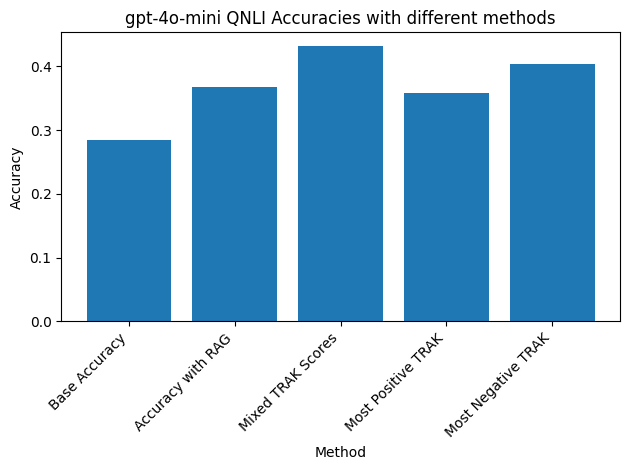

In [24]:
accuracies = {
    "Base Accuracy": accuracy,
    "Accuracy with RAG": accuracy_rag,
    "Mixed TRAK Scores": accuracy_pe,
    "Most Positive TRAK": accuracy_pe_positive,
    "Most Negative TRAK": accuracy_pe_negative,
}

# Plotting the accuracies
plt.figure()
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel("Method")
plt.ylabel("Accuracy")
plt.title(f"{model} QNLI Accuracies with different methods")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.savefig(f"qnli_accuracies_{model}.png")
plt.show()